# H2O



In [5]:
#import turbodbc
import numpy as np
import pandas as pd
import datetime
import sys

import h2o
import configparser

In [8]:
config = configparser.ConfigParser()
config.read('settings.ini')
login = config['MAIN']['login']
password = config['MAIN']['password']

## Launching

In [ ]:
with open('info.txt') as f:
    first_line = f.readline().strip()
ip = first_line.split(':')[0]
host = first_line.split(':')[1]

h2o.connect(ip=ip, port=host, auth = (login, password))

In [ ]:
h2o.cluster().show_status()

## Loading data into H2O

In [18]:
sql = """
      select top 100 *
        from table_name 
      """

In [19]:
%%time
connection = turbodbc.connect(dsn='Teradata')
cursor = connection.cursor()
cursor.execute(sql)
data = pd.DataFrame(cursor.fetchallnumpy())

Wall time: 1min 55s


In [20]:
data.head()

,log_income,bin_income,report_month,SUBS_ID,current_imei,model_user_count,tac_user_count,buy_price,current_price,months_between_buy_min,...,avg_months_since_min,min_months_since_buy,max_months_since_buy,avg_months_since_buy,min_buy_price_to_discount_division,max_buy_price_to_discount_division,avg_buy_price_to_discount_division,min_buy_price_to_discount_subtraction,max_buy_price_to_discount_subtraction,avg_buy_price_to_discount_subtraction
0,10.488466,1.0,2018-03-01,18333019,86730001825621,985.0,818,13332,9192,48,...,64.0,16,16,16.0,0.872742,0.872742,0.872742,-1944,-1944,-1944.0
1,NaN,NaN,2018-03-01,100028789231,86654203080636,4097.0,3967,13334,13334,16,...,22.5,0,16,8.0,1.000000,1.181778,1.090889,0,2051,1025.5
2,12.451415,3.0,2018-03-01,200034716639,35709105324344,72745.0,205,6334,3548,39,...,55.0,16,16,16.0,0.982930,0.982930,0.982930,-110,-110,-110.0
3,11.896240,2.0,2018-03-01,100040993294,35812807019662,35331.0,32296,21800,13155,5,...,21.0,16,16,16.0,1.505525,1.505525,1.505525,7320,7320,7320.0
4,12.270267,3.0,2018-03-01,39254634,86093503140055,10278.0,9534,19481,13554,10,...,17.0,7,7,7.0,1.000000,1.000000,1.000000,0,0,0.0


### 1.From python object

In [24]:
%%time
h2o_df = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Wall time: 1min


### 2. Upload

In [21]:
data1 = h2o.upload_file('1.csv', destination_frame='data')

Parse progress: |█████████████████████████████████████████████████████████| 100%


### 3. From Hive

In [ ]:
h2o.import_file('path_to_table', destination_frame='data2',
               col_names=[])

In [86]:
data2 = h2o.get_frame('data2')

### 4. Sparse

In [17]:
h2o.import_file('', destination_frame='to_sparse',
               col_names=['subs_id', 'dest_number'])


Parse progress: |█████████████████████████████████████████████████████████| 100%


subs_id,dest_number
1.00036e+11,7.90412e+10
1.00036e+11,7.95014e+10
1.00036e+11,7.8125e+10
1.00036e+11,7.90252e+10
1.00036e+11,7.4997e+10
5.88477e+06,7.90142e+10
5.90104e+06,7.38423e+10
5.98106e+06,6.84865e+08
6.08409e+06,7.92516e+10
6.44601e+06,7.90377e+10


In [18]:
df_sp = h2o.get_frame('to_sparse')

In [19]:
df = df_sp.as_data_frame()

In [80]:
print(df.shape)
df.head()

(243562, 3)

In [66]:
df = df.dropna()

In [67]:
subs_dict = {i: e for i, e in enumerate(df.subs_id.unique())}
subs_dict_inv = {e: i for i, e in enumerate(df.subs_id.unique())}
dest_dict = {i: int(e) for i, e in enumerate(df.dest_number.unique())}
dest_dict_inv = {int(e): i for i, e in enumerate(df.dest_number.unique())}
df['subs_id'] = df['subs_id'].apply(lambda x: subs_dict_inv[x])
df['dest_number'] = df['dest_number'].apply(lambda x: dest_dict_inv[x])

In [74]:
df['v'] = 1

In [76]:
import scipy.sparse as sps
df_sp = sps.csr_matrix((df['v'], (df['subs_id'], df['dest_number'])))

In [77]:
h2o_sparse = h2o.H2OFrame(df_sp)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [82]:
h2o_sparse.head(rows=20, cols=20)

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Processing data

In [35]:
data2.head(5)

subs_id,changed,branch,lifetime,phone_type,cpe_m_age,cpe_p_age,cpe_popularity,dev_park_size,av_dev_use,max_dev_use,gender,age,days_with_data_trafic,cpe_manufacturer_name
3.09407e+07,\N,B39,2376,P1,558,243,4.68878,6,187.125,596,G0,38,30,\N
5.06364e+06,\N,B2,4450,P1,562,361,3.67108,4,175.444,613,G0,52,0,\N
3.26094e+07,\N,B54,2049,P1,823,251,4.47056,5,30.8667,402,G0,37,0,\N
2.35935e+07,\N,B54,3311,P2,2436,2073,5.02572,1,2073,2073,G1,30,0,Philips
5.11392e+07,\N,B35,171,P1,559,171,4.85658,9,108.357,842,G0,44,29,\N


In [117]:
%%time
h2o.import_file('', 'churn_labels',
               col_names=['label', 'subs_id'])

Parse progress: |█████████████████████████████████████████████████████████| 100%
CPU times: user 205 ms, sys: 16.1 ms, total: 221 ms
Wall time: 8.23 s


label,subs_id
true,2.00029e+11
true,2.00029e+11
true,2.00029e+11
true,2.00029e+11
true,2.00029e+11
true,2.0003e+11
true,2.0003e+11
true,2.0003e+11
true,2.0003e+11
true,2.0003e+11


In [57]:
f = h2o.get_frame('churn_labels')

In [58]:
f['label'].levels()

[['true']]

In [118]:
%%time
col_names1 = pd.read_csv('3.csv')
col_names1 = list(col_names1.col_name)
h2o.import_file(', 'churn_df',
               col_names=col_names1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
CPU times: user 526 ms, sys: 42.2 ms, total: 568 ms
Wall time: 45.7 s


In [60]:
data = h2o.get_frame('churn_df')

In [ ]:
data.describe()

In [62]:
for col in data.columns:
    if data[col].isna().any():
        print(col, data[col].isna().any())

age True
os_version True
os_id True
popularity True
popalive True
plc_type True
doc_age True
email_domain True


In [64]:
data['age'].any_na_rm()

True

In [ ]:
for i in data.columns_by_type('categorical'):
    print(int(i), data.columns[int(i)])

In [66]:
data['gender'].table()

gender,Count
G0,1.05202e+07
G1,1.20927e+07
\N,1.65663e+06


In [69]:
data['label'].levels()

[['\\N', 'true']]

In [72]:
data['label'] = data['label'].set_levels(['1', '0'])

In [50]:
h2o.remove('purchase_df1')

In [73]:
data[data['age'].isna(), 'age'] = 43

In [77]:
data.type('age')

'int'

In [ ]:
data['age'] = data['age'].asnumeric()

In [78]:
data['5'] = data['sd_day_mou'] * data['cl_smartphones_share']
data[data['cl_smartphones_share'] == 0, '6'] = 0

In [79]:
data['fold_column'] = data.kfold_column()

In [80]:
data['cpe_p_age_root'] = data['cpe_p_age'] ** 0.5
data['start_lag_log'] = data['start_lag'].log1p()

In [82]:
x = data.group_by(by=['gender'])
y = x.mean(col='cpe_p_age_root',na="all").get_frame()
y

gender,mean_cpe_p_age_root
G0,16.3078
G1,17.3928
\N,19.9837


In [1]:
#data.head()

In [90]:
data.interaction(factors=[1, 2, 3], pairwise=True, max_factors=1000000, min_occurrence=10, destination_frame='data_interaction')
data_int = h2o.get_frame('data_interaction')
data_full = data.cbind(data_int)

Interactions progress: |██████████████████████████████████████████████████| 100%


## Model

Modeling In H2O
- H2OEstimator
- H2ODeepLearningEstimator
- H2OAutoEncoderEstimator
- H2ORandomForestEstimator
- H2OGradientBoostingEstimator
- H2OGeneralizedLinearEstimator
- H2OGeneralizedLowRankEstimator
- H2OKMeansEstimator
- H2ONaiveBayesEstimator

In [99]:
gbm = h2o.estimators.gbm.H2OGradientBoostingEstimator(ntrees=10, max_depth=5, min_rows=2, learn_rate=0.1,
                                                                 #balance_classes=True,
                                                                 #fold_assignment='Stratified', nfolds=3,
                                                                col_sample_rate=1.0, sample_rate=1.0,
                                                                learn_rate_annealing=0.999,
                                                                #class_sampling_factors=[1.0, 10.0]
                                                     )

In [85]:
train, val, test = data.split_frame(ratios=[0.8, 0.1])

In [ ]:
splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

In [93]:
cols = []

In [100]:
%%time
gbm.train(x=cols, y='label', training_frame=train, validation_frame=val)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: user 490 ms, sys: 34 ms, total: 524 ms
Wall time: 54.9 s


In [2]:
#gbm

In [3]:
#gbm.varimp(True)

In [105]:
path = h2o.save_model(gbm, path='path')
#model = h2o.load_model(path)
#gbm_regressor.download_mojo(path='hdfs://T2-HDFS-HA-PROD/user/andrey.lukyanenko', get_genmodel_jar=True, genmodel_name='gen')

In [119]:
model = h2o.load_model('path')

In [4]:
#gbm.model_performance(test)

In [109]:
gbm.auc()

0.6476486781814623

In [111]:
%matplotlib inline

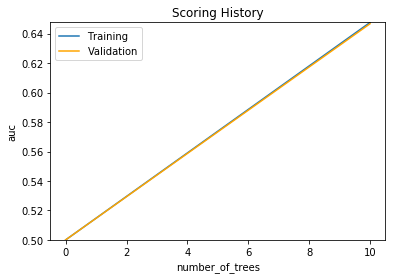

In [112]:
gbm.plot(metric='auc')

In [94]:
# Import H2O Grid Search:
from h2o.grid.grid_search import H2OGridSearch

# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [96]:
# GBM hyperparameters
gbm_params = {'learn_rate': [0.1], 
                'max_depth': [3, 9, 15],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.8, 1.0],
                'ntrees': [10, 20, 30]}

In [98]:
%%time
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid.train(x=h2o_df.columns[4:48], y='log_income', training_frame=train, 
                validation_frame=val, 
                seed=1)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Wall time: 24min 30s


In [101]:
gbm_gridperf = gbm_grid.get_grid(sort_by='mae', decreasing=True)

In [123]:
gbm_gridperf

     col_sample_rate learn_rate max_depth ntrees sample_rate  \
0                0.8        0.1         3     10         0.8   
1                1.0        0.1         3     10         1.0   
2                0.8        0.1         3     10         1.0   
3                1.0        0.1         3     10         0.8   
4                0.8        0.1         3     20         0.8   
5                1.0        0.1         3     20         1.0   
6                0.8        0.1         3     20         1.0   
7                1.0        0.1         3     20         0.8   
8                0.8        0.1         3     30         0.8   
9                1.0        0.1         3     30         1.0   
10               1.0        0.1         3     30         0.8   
11               0.8        0.1         3     30         1.0   
12               0.8        0.1         9     10         0.8   
13               0.8        0.1         9     10         1.0   
14               1.0        0.1         

In [118]:
gbm_grid

     col_sample_rate learn_rate max_depth ntrees sample_rate  \
0                1.0        0.1         9     30         1.0   
1                0.8        0.1         9     30         1.0   
2                1.0        0.1         9     30         0.8   
3                0.8        0.1         9     30         0.8   
4                1.0        0.1         9     20         1.0   
5                0.8        0.1         9     20         1.0   
6                1.0        0.1         9     20         0.8   
7                0.8        0.1         9     20         0.8   
8                0.8        0.1        15     20         1.0   
9                0.8        0.1        15     20         0.8   
10               0.8        0.1        15     30         1.0   
11               1.0        0.1        15     20         0.8   
12               0.8        0.1        15     10         0.8   
13               0.8        0.1        15     10         1.0   
14               1.0        0.1        1

In [5]:
#gbm_gridperf.models[-1]

In [6]:
#gbm_gridperf.models[0].model_performance(test)

In [107]:
pr = gbm_gridperf1.models[0].predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [113]:
pr = gbm.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [14]:
h2o.export_file(pr, 'path_to_file')

Export File progress: |███████████████████████████████████████████████████| 100%


In [7]:
#h2o.save_model(gbm_regressor, 'folder')

In [114]:
pr

predict,p1,p0
0,0.061673,0.938327
0,0.0560675,0.943933
0,0.0987542,0.901246
0,0.0874604,0.91254
0,0.049448,0.950552
0,0.0518455,0.948155
0,0.0597316,0.940268
0,0.0932738,0.906726
0,0.0615082,0.938492
0,0.049448,0.950552
